# Importance of XCov term in loss function
- How does the model behave differently without XCov?
- Does amount of input variation matter? (None,Med,hi)?

In [1]:
import os
import json
import numpy as np
import pandas as pd
import scipy

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from src.data_loader import Shifted_Data_Loader
from src.plot import orig_vs_transformed as plot_ovt
from src.plot import enc_dec_samples
from src.models import GResNet,EDense
from src.config import get_config
from src.trainer import Trainer
from src.utils import prepare_dirs_and_logger
from keras.datasets import fashion_mnist,mnist
from keras.layers import Dense
from keras.models import Model
# from tabulate import tabulate

Using TensorFlow backend.


In [21]:
config,_ = get_config()
# Boilerplate
setattr(config, 'proj_root', '/home/elijahc/projects/vae')
setattr(config, 'log_dir', '/home/elijahc/projects/vae/logs')
setattr(config, 'dev_mode',False)
setattr(config,'model_dir','/home/elijahc/projects/vae/models/2019-03-28/')
setattr(config, 'seed', 7)
setattr(config, 'project','vae')
setattr(config, 'ecc_max',None)

# Architecture Params
setattr(config, 'enc_layers', [3000,2000])
setattr(config, 'dec_blocks', [4,2,1])
setattr(config, 'z_dim', 25)
setattr(config, 'y_dim', 10)

# Training Params
setattr(config, 'batch_size', 512)
setattr(config, 'dataset', 'fashion_mnist')
setattr(config, 'epochs',150)
setattr(config, 'monitor', None)
# setattr(config, 'min_delta', 0.5)
setattr(config, 'optimizer', 'adam')

# Loss Weights
setattr(config, 'xcov', 0)
setattr(config, 'recon', 0)
setattr(config, 'xent', 15)

In [22]:
np.random.seed(7)
if not config.dev_mode:
    print('setting up...')
    prepare_dirs_and_logger(config)
    
vars(config)


setting up...
/home/elijahc/projects/vae/models/2019-03-28/  does not exist...
creating...
/home/elijahc/projects/vae/logs/0327_170434_fashion_mnist  does not exist...
creating...


{'batch_size': 512,
 'dataset': 'fashion_mnist',
 'dec_blocks': [4, 2, 1],
 'dev_mode': False,
 'ecc_max': None,
 'enc_layers': [3000, 2000],
 'epochs': 150,
 'log_dir': '/home/elijahc/projects/vae/logs',
 'log_level': 'INFO',
 'model_dir': '/home/elijahc/projects/vae/models/2019-03-28/',
 'model_name': '0327_170434_fashion_mnist',
 'monitor': None,
 'optimizer': 'adam',
 'proj_root': '/home/elijahc/projects/vae',
 'project': 'vae',
 'recon': 0,
 'run_dir': '/home/elijahc/projects/vae/logs/0327_170434_fashion_mnist',
 'seed': 7,
 'xcov': 0,
 'xent': 15,
 'y_dim': 10,
 'z_dim': 25}

In [4]:
translation_amt = config.ecc_max # Med
DL = Shifted_Data_Loader(dataset=config.dataset,flatten=True,
                         rotation=None,
                         translation=translation_amt,
                        )

input_shape:  (3136,)
dataset:  fashion_mnist
scale:  2
tx_max:  None
rot_max:  None
loading fashion_mnist...
sx_train:  (60000, 3136)
making training data...
making testing data...


In [5]:
G_builder = GResNet(y_dim=config.y_dim,z_dim=config.z_dim,dec_blocks=config.dec_blocks)
E_builder = EDense(enc_layers=config.enc_layers,z_dim=config.z_dim,)
trainer = Trainer(config,DL,E_builder,G_builder,)
# setattr(trainer.config,'model_dir','/home/elijahc/projects/vae/models/2019-01-22/')

building encoder...
building decoder/generator...


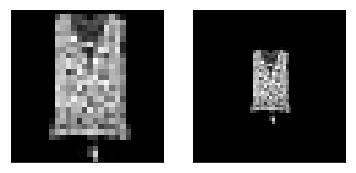

In [6]:
pt,idx = plot_ovt(DL,cmap='gray')

In [7]:
trainer.model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_image (InputLayer)        (None, 3136)         0                                            
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 3000)         9411000     input_image[0][0]                
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 2000)         6002000     dense_1[0][0]                    
__________________________________________________________________________________________________
enc_merge (Dense)               (None, 36)           72036       dense_2[0][0]                    
__________________________________________________________________________________________________
lambda_1 (

In [8]:
import keras.backend as K
K.int_shape(trainer.model.outputs[0])

(None, 3136)

In [9]:
# trainer.build_model()
trainer.compile_model()
# trainer.G.summary()

In [10]:
# Load corrupted Labels
y_tr_corr = np.load('../data/fashion_mnist_corrupted_labels/y_train_0.8.npy')

In [11]:
from keras.utils import to_categorical
y_corrupted_oh = to_categorical(y_tr_corr,num_classes=10)

In [12]:
y_corrupted_oh.shape

(60000, 10)

In [13]:
trainer.model.output

[<tf.Tensor 'G/G_image_flat/Reshape:0' shape=(?, ?) dtype=float32>,
 <tf.Tensor 'class/Softmax:0' shape=(?, 10) dtype=float32>]

In [14]:
# trainer.G.summary()
G_out = trainer.G.get_layer('G_image_flat')
trainer.E.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_image (InputLayer)        (None, 3136)         0                                            
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 3000)         9411000     input_image[0][0]                
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 2000)         6002000     dense_1[0][0]                    
__________________________________________________________________________________________________
enc_merge (Dense)               (None, 36)           72036       dense_2[0][0]                    
__________________________________________________________________________________________________
lambda_1 (

In [15]:
trainer.go(x=DL.sx_train,
           y={
               'class':y_corrupted_oh,
#                'D_real':RF,
               'G':DL.sx_train},
           validation_split=0.05,
           verbose=0)

Epoch        G_loss      val_G_loss  class_acc   val_class_acc
0:           1468.5307   1382.2067   0.3919      0.405       
1:           1467.4736   1354.4873   0.4306      0.4153      
2:           1437.3241   1381.5098   0.4371      0.4107      
3:           1420.1366   1416.7252   0.4411      0.418       
4:           1407.1019   1373.6635   0.4464      0.4143      
5:           1389.2221   1399.3867   0.4481      0.4127      
6:           1378.1851   1430.2324   0.4518      0.419       
7:           1376.4999   1351.8749   0.4534      0.4183      
8:           1371.2405   1378.5126   0.4563      0.42        
9:           1372.5902   1376.4775   0.4588      0.4157      
10:          1359.9122   1354.2595   0.4606      0.4083      
11:          1359.4853   1381.561    0.463       0.413       
12:          1349.175    1354.152    0.4687      0.4127      
13:          1328.2176   1326.7798   0.4731      0.41        
14:          1305.0785   1333.6283   0.4776      0.4127      
15:    

In [16]:
hist_df = pd.DataFrame.from_records(trainer.model.history.history)
hist_df.head()

,G_loss,G_mse,class_acc,class_loss,loss,val_G_loss,val_G_mse,val_class_acc,val_class_loss,val_loss
0,1468.530746,1468.530746,0.391947,2.000726,30.017345,1382.206735,1382.206735,0.405000,1.995374,29.934440
1,1467.473579,1467.473579,0.430632,1.922380,28.838178,1354.487274,1354.487274,0.415333,1.963376,29.452104
2,1437.324110,1437.324110,0.437088,1.903012,28.546129,1381.509800,1381.509800,0.410667,1.974720,29.621349
3,1420.136633,1420.136633,0.441105,1.890788,28.362165,1416.725242,1416.725242,0.418000,1.966051,29.490971
4,1407.101950,1407.101950,0.446351,1.878628,28.179551,1373.663488,1373.663488,0.414333,1.959293,29.389465


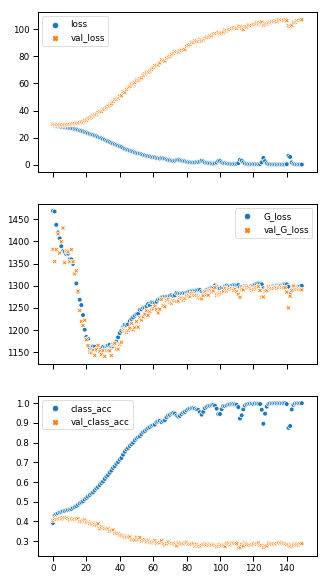

In [17]:
sns.set_context('paper')
metrics = ['loss','G_loss','class_acc']
fig,axs = plt.subplots(nrows=len(metrics),sharex=True,figsize=(5,10))
for metric_name,ax in zip(metrics,axs):
    sns.scatterplot(data=hist_df[[metric_name,'val_'+metric_name]],ax=ax)

In [18]:
import datetime as dt
def clean_config(config,keys=['dev_mode','log_dir','log_level','proj_root']):
    c = vars(config)
    for k in keys:
        if k in c.keys():
            del c[k]
    
    c['uploaded_by']='elijahc'
    c['last_updated']= str(dt.datetime.now())
    return c

In [19]:
run_meta = clean_config(config)
run_meta['project']='vae'
# run_meta['ecc_max']=0.8
run_meta

{'batch_size': 512,
 'dataset': 'fashion_mnist',
 'dec_blocks': [4, 2, 1],
 'ecc_max': None,
 'enc_layers': [3000, 2000],
 'epochs': 150,
 'last_updated': '2019-03-27 16:39:25.122492',
 'model_dir': '/home/elijahc/projects/vae/models/2019-03-28/',
 'monitor': None,
 'optimizer': 'adam',
 'project': 'vae',
 'recon': 0,
 'seed': 7,
 'uploaded_by': 'elijahc',
 'xcov': 0,
 'xent': 15,
 'y_dim': 10,
 'z_dim': 25}

In [23]:
trainer.save_model()
run_conf = clean_config(config)

with open(os.path.join(run_conf['model_dir'],'config.json'), 'w') as fp:
    json.dump(run_conf, fp)

hist_df.to_parquet(os.path.join(run_conf['model_dir'],'train_history.parquet'))

In [24]:
generator = trainer.G

In [25]:
trainer.E.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_image (InputLayer)        (None, 3136)         0                                            
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 3000)         9411000     input_image[0][0]                
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 2000)         6002000     dense_1[0][0]                    
__________________________________________________________________________________________________
enc_merge (Dense)               (None, 36)           72036       dense_2[0][0]                    
__________________________________________________________________________________________________
lambda_1 (

In [26]:
trainer.model.get_layer(name='dense_1').output

<tf.Tensor 'dense_1/Relu:0' shape=(?, 3000) dtype=float32>

In [27]:
z_encoder = Model(trainer.input,trainer.z_lat)
classifier = Model(trainer.input,trainer.y_class)

l1_encoder = Model(trainer.input,trainer.model.get_layer(name='dense_1').output)
l2_encoder = Model(trainer.input,trainer.model.get_layer(name='dense_2').output)

In [28]:
z_w_k = K.get_value(z_encoder.get_layer('enc_merge').weights[0])[:,10:-1]

(array([68., 64., 68., 68., 65., 55., 62., 56., 57., 72., 59., 77., 63.,
        72., 59., 81., 55., 65., 57., 56., 65., 70., 48., 62., 61., 62.,
        69., 72., 71., 66., 75.]),
 array([-0.05421356, -0.05071754, -0.04722151, -0.04372548, -0.04022945,
        -0.03673343, -0.0332374 , -0.02974137, -0.02624534, -0.02274932,
        -0.01925329, -0.01575726, -0.01226123, -0.00876521, -0.00526918,
        -0.00177315,  0.00172288,  0.0052189 ,  0.00871493,  0.01221096,
         0.01570699,  0.01920302,  0.02269904,  0.02619507,  0.0296911 ,
         0.03318712,  0.03668315,  0.04017918,  0.04367521,  0.04717124,
         0.05066726,  0.05416329], dtype=float32),
 <a list of 31 Patch objects>)

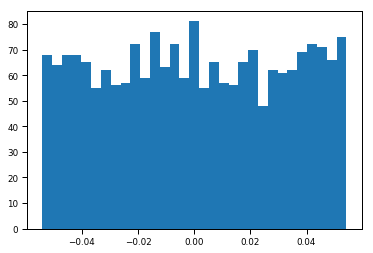

In [29]:
plt.hist(z_w_k[:,7],bins=31)

(array([1618., 1613., 1643., 1581., 1659., 1571., 1623., 1537., 1606.,
        1611., 1613., 1662., 1572., 1608., 1596., 1617., 1624., 1630.,
        1516., 1664., 1600., 1580., 1626., 1642., 1605., 1617., 1651.,
        1628., 1584., 1637., 1666.]),
 array([-0.05428564, -0.05078338, -0.04728112, -0.04377886, -0.04027659,
        -0.03677433, -0.03327207, -0.02976981, -0.02626755, -0.02276529,
        -0.01926303, -0.01576077, -0.01225851, -0.00875624, -0.00525398,
        -0.00175172,  0.00175054,  0.0052528 ,  0.00875506,  0.01225732,
         0.01575959,  0.01926185,  0.02276411,  0.02626637,  0.02976863,
         0.03327089,  0.03677315,  0.04027541,  0.04377768,  0.04727994,
         0.0507822 ,  0.05428446], dtype=float32),
 <a list of 31 Patch objects>)

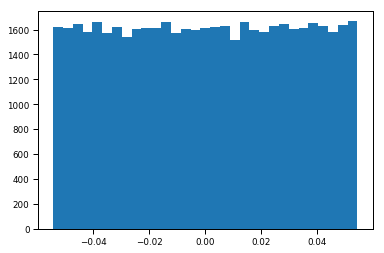

In [30]:
plt.hist(z_w_k.flatten(),bins=31)

In [31]:
classifier.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_image (InputLayer)     (None, 3136)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 3000)              9411000   
_________________________________________________________________
dense_2 (Dense)              (None, 2000)              6002000   
_________________________________________________________________
enc_merge (Dense)            (None, 36)                72036     
_________________________________________________________________
lambda_1 (Lambda)            [(None, 10), (None, 25),  0         
_________________________________________________________________
class (Activation)           (None, 10)                0         
Total params: 15,485,036
Trainable params: 15,485,036
Non-trainable params: 0
________________________________________________________________

In [32]:
DL.y_test_oh.shape

(10000, 10)

In [33]:
classifier.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['acc'])
classifier.evaluate(DL.sx_test,DL.y_test_oh,batch_size=config.batch_size)

10000/10000 [==============================] - 0s 32us/step


[2.8417589660644533, 0.5656999999046326]

In [34]:
z_enc = z_encoder.predict(DL.sx_test,batch_size=config.batch_size)
l1_enc = l1_encoder.predict(DL.sx_test,batch_size=config.batch_size)
l2_enc = l2_encoder.predict(DL.sx_test,batch_size=config.batch_size)
# y_lat = y_lat_encoder.predict(DL.sx_test,batch_size=config.batch_size)
y_lat = classifier.predict(DL.sx_test,batch_size=config.batch_size)

In [35]:
l2_enc.shape

(10000, 2000)

In [36]:
_lat_vec = np.concatenate([y_lat,z_enc],axis=1)
_lat_vec.shape

(10000, 35)

In [37]:
z_enc_mu = np.mean(z_enc,axis=0)
z_enc_cov = np.cov(z_enc,rowvar=False)

In [38]:
np.random.multivariate_normal(z_enc_mu,z_enc_cov,size=50).shape

(50, 25)

In [39]:
regen = generator.predict(_lat_vec,batch_size=config.batch_size)

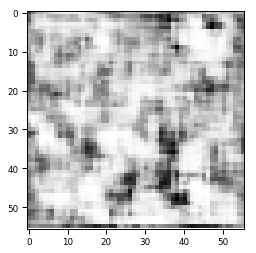

In [40]:
rand_im = np.random.randint(0,10000)
plt.imshow(regen[rand_im].reshape(56,56),cmap='gray')

In [41]:
_lat_vec[rand_im]

array([ 1.0918759e-01,  1.6671871e-03,  2.9946511e-04,  9.2745904e-05,
        7.1235648e-03,  8.8155180e-01,  6.5739165e-05,  8.6603001e-07,
        6.9293264e-08,  1.0923496e-05,  4.2274788e-02, -2.5561299e-02,
        4.1399479e-01,  6.0253465e-01, -1.7411461e-01, -3.1582645e-01,
        7.1400516e-02,  3.2715109e-01, -4.8567542e-01, -1.2039887e-01,
        4.3924022e-01,  8.7832195e-01,  1.2887082e-01,  6.8330532e-01,
       -7.7269077e-01, -7.4720252e-01, -6.3901588e-02,  8.7956685e-01,
        5.2469569e-01, -7.3718768e-01, -3.2056934e-01,  5.9964424e-01,
        4.5482212e-01, -5.4698497e-01, -1.0353476e-02], dtype=float32)

In [42]:
DL2 = Shifted_Data_Loader(dataset=config.dataset,flatten=True,
                         rotation=None,
                         translation=translation_amt,
                        )

input_shape:  (3136,)
dataset:  fashion_mnist
scale:  2
tx_max:  None
rot_max:  None
loading fashion_mnist...
sx_train:  (60000, 3136)
making training data...
making testing data...


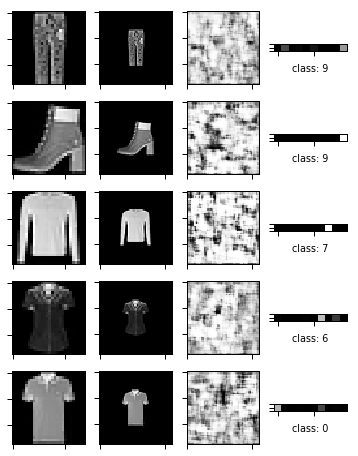

In [43]:
enc_dec_samples(DL.x_test,DL.sx_test,z_enc,y_lat,generator)

In [44]:
z_enc2 = z_encoder.predict(DL2.sx_test,batch_size=config.batch_size)
y_lat2 = classifier.predict(DL2.sx_test,batch_size=config.batch_size)
_lat_vec2 = np.concatenate([y_lat2,z_enc2],axis=1)
regen2 = generator.predict(_lat_vec2,batch_size=config.batch_size)

In [ ]:
from src.plot import remove_axes,remove_labels
from src.utils import gen_trajectory

In [ ]:
examples = 5
rand_im = np.random.randint(0,10000,size=examples)
fix,axs = plt.subplots(examples,11,figsize=(8,4))
_lat_s = []
regen_s = []
out = gen_trajectory(z_enc[rand_im],z_enc2[rand_im],delta=.25)
out_y = gen_trajectory(y_lat[rand_im],y_lat2[rand_im],delta=.25)

for z,y in zip(out,out_y):
    _lat = np.concatenate([y,z],axis=1)
    _lat_s.append(_lat)
    regen_s.append(generator.predict(_lat,batch_size=config.batch_size))

i=0
for axr,idx in zip(axs,rand_im):
    axr[0].imshow(DL.x_test[idx].reshape(28,28),cmap='gray')
    axr[1].imshow(DL.sx_test[idx].reshape(56,56),cmap='gray')
    axr[2].imshow(regen[idx].reshape(56,56),cmap='gray')
    for j,a in enumerate(axr[3:-3]):
        a.imshow(regen_s[j][i,:].reshape(56,56),cmap='gray')
#         a.imshow(s.reshape(56,56),cmap='gray')
    axr[-3].imshow(regen2[idx].reshape(56,56),cmap='gray')
    axr[-2].imshow(DL2.sx_test[idx].reshape(56,56),cmap='gray')
    axr[-1].imshow(DL2.x_test[idx].reshape(28,28),cmap='gray')
    for a in axr:
        remove_axes(a)
        remove_labels(a)
    i+=1
# plt.imshow(regen[rand_im].reshape(56,56),cmap='gray')

In [ ]:
# fix.savefig('../../updates/2019-02-05/assets/img/translocate_{}.png'.format(translation_amt))

In [ ]:
dxs = DL.dx[1]-14
dys = DL.dy[1]-14

In [ ]:
from sklearn.preprocessing import MinMaxScaler

feat_range = (0,30)
z_enc_scaled = [MinMaxScaler(feat_range).fit_transform(z_enc[:,i].reshape(-1,1)).tolist() for i in np.arange(25)]
z_enc_scaled = np.squeeze(np.array(z_enc_scaled,dtype=int))

In [ ]:
l2_enc_scaled = [MinMaxScaler(feat_range).fit_transform(l2_enc[:,i].reshape(-1,1)).tolist() for i in np.arange(2000)]
l2_enc_scaled = np.squeeze(np.array(l2_enc_scaled,dtype=int))

In [ ]:
l2_enc_scaled.shape

In [ ]:
from collections import Counter
import dit
from dit import Distribution

def mutual_information(X,Y):
    XY_c = Counter(zip(X,Y))
    XY_pmf = {k:v/float(sum(XY_c.values())) for k,v in XY_c.items()}
    XY_jdist = Distribution(XY_pmf)
        
    return dit.shannon.mutual_information(XY_jdist,[0],[1])

In [ ]:
z_dx_I = [mutual_information(z_enc_scaled[i],dxs.astype(int)+14) for i in np.arange(25)]
l2_dx_I = [mutual_information(l2_enc_scaled[i],dxs.astype(int)+14) for i in np.arange(2000)]

In [ ]:
z_dy_I = [mutual_information(z_enc_scaled[i],dys.astype(int)+14) for i in np.arange(25)]
l2_dy_I = [mutual_information(l2_enc_scaled[i],dys.astype(int)+14) for i in np.arange(2000)]

In [ ]:
z_class_I = [mutual_information(z_enc_scaled[i],DL.y_test) for i in np.arange(25)]
l2_class_I = [mutual_information(l2_enc_scaled[i],DL.y_test) for i in np.arange(2000)]

In [ ]:
z_I_df = pd.DataFrame.from_records({'class':z_class_I,'dy':z_dy_I,'dx':z_dx_I})
z_I_df['class'] = z_I_df['class'].values.round(decimals=1)

In [ ]:
l2_I_df = pd.DataFrame.from_records({
    'class':l2_class_I,
    'dy':l2_dy_I,
    'dx':l2_dx_I})
l2_I_df['class'] = l2_I_df['class'].values.round(decimals=1)

In [ ]:
l2_I_df.head()

In [ ]:
plt.hist(l2_I_df.dx)

In [ ]:
plt.hist(z_I_df.dx)

In [ ]:
config.translation_amt = translation_amt
config.translation_amt

In [ ]:
dir_path = '../data/xcov_importance/dist_{}/'.format(translation_amt)

z_I_df.to_pickle('../data/xcov_importance/dist_{}/z_mutual_info.pk'.format(translation_amt))
np.save('../data/xcov_importance/dist_{}/dxs'.format(translation_amt), DL.dx[1]-14)
np.save('../data/xcov_importance/dist_{}/dys'.format(translation_amt), DL.dy[1]-14)
np.save('../data/xcov_importance/dist_{}/z_enc'.format(translation_amt), z_enc)

hist_df.to_pickle(os.path.join(dir_path,'training_hist.df'))

with open(os.path.join(dir_path,'config.json'), 'w') as fp:
        json.dump(vars(config), fp)

In [ ]:
def filter_by_weight(wts,thresh=0.01):
    idxs = np.abs(wts)>thresh
    return idxs

In [ ]:
dx_max = np.argmax(z_I_df.dx.values)
dy_max = np.argmax(z_I_df.dy.values)

In [ ]:
t = 0.05
dx_filt = filter_by_weight(z_w_k[:,dx_max],thresh=t)
dy_filt = filter_by_weight(z_w_k[:,dy_max],thresh=t)
union = np.union1d(np.where(dx_filt==True),np.where(dy_filt==True))
intersect = np.intersect1d(np.where(dx_filt==True),np.where(dy_filt==True))
# filt = np.array([False]*2000)
# filt[union] = True

sns.set_context('talk')
fig,axs = plt.subplots(1,2,figsize=(6*2,5))

filt = dy_filt
print('num: ',len(union))
print('intersect_frac: ',float(len(intersect))/len(union))
print('mean dx_I: ',l2_I_df.dx[filt].mean())
print('mean dy_I: ',l2_I_df.dy[filt].mean())
points = axs[0].scatter(x=l2_I_df['dx'],y=l2_I_df['dy'],
                        c=l2_I_df['class'],cmap='viridis',vmin=0,vmax=0.4,s=z_I_df['class']*100
                       )
plt.colorbar(points)
points = axs[1].scatter(x=z_I_df['dx'],y=z_I_df['dy'],c=z_I_df['class'],cmap='viridis',s=z_I_df['class']*100,vmin=0,vmax=0.4)
# plt.colorbar(points)
axs[0].set_ylim(0,0.9)
axs[0].set_xlim(0,0.9)
axs[1].set_ylim(0,0.9)
axs[1].set_xlim(0,0.9)


In [ ]:
fig,ax = plt.subplots(1,1,figsize=(5,5))
ax.scatter(z_dx_I,z_dy_I)
# ax.set_ylim(0,0.8)
# ax.set_xlim(0,0.8)

In [ ]:
plt.scatter(np.arange(25),sorted(z_class_I,reverse=True))
# plt.scatter(np.arange(25),z_dx_I)
# plt.scatter(np.arange(25),z_dy_I)

In [ ]:
from src.metrics import var_expl,norm_var_expl
from collections import Counter

dtheta = DL.dtheta[1]
fve_dx = norm_var_expl(features=z_enc,cond=dxs,bins=21)
fve_dy = norm_var_expl(features=z_enc,cond=dys,bins=21)
fve_class = norm_var_expl(features=z_enc, cond=DL.y_test, bins=21)
# fve_dt = norm_var_expl(features=z_enc,cond=dtheta,bins=21)

In [ ]:
# fve_dx_norm = (dxs.var()-fve_dx)/dxs.var()
# fve_dy_norm = (dys.var()-fve_dy)/dys.var()
# fve_dth_norm = (dtheta.var()-fve_dt)/dtheta.var()
fve_dx_norm = fve_dx
fve_dy_norm = fve_dy

In [ ]:
import seaborn as sns
sns.set_context('talk')

In [ ]:
fve_dx_norm.shape
# np.save(os.path.join(config.model_dir,'fve_dx_norm'),fve_dx_norm)

In [ ]:
fig,ax = plt.subplots(1,1,figsize=(5,5))
plt.scatter(fve_dx_norm.mean(axis=0),fve_dy_norm.mean(axis=0))
plt.xlabel('fve_dx')
plt.ylabel('fve_dy')
plt.tight_layout()
# plt.savefig(os.path.join(config.model_dir,'fve_dx.png'))
# plt.ylim(-0.125,0.25)
xdim = np.argmax(fve_dx_norm.mean(axis=0))

In [ ]:
fve_dy_norm.mean(axis=0)
# np.save(os.path.join(config.model_dir,'fve_dy_norm'),fve_dy_norm)

In [ ]:
plt.scatter(np.arange(config.z_dim),fve_dy_norm.mean(axis=0))
plt.xlabel('Z_n')
plt.ylabel('fve_dy')
plt.tight_layout()
# plt.savefig(os.path.join(config.model_dir,'fve_dy.png'))
# plt.ylim(-0.125,0.25)
ydim = np.argmax(fve_dy_norm.mean(axis=0))

In [ ]:
plt.scatter(np.arange(config.z_dim),fve_class.mean(axis=0))
plt.xlabel('Z_n')
plt.ylabel('fve_class')
# plt.ylim(0.0,0.5)
np.argmax(fve_class.mean(axis=0))

In [ ]:
from src.plot import Z_color_scatter
Z_color_scatter(z_enc,[xdim,ydim],dxs)

In [ ]:
Z_color_scatter(z_enc,[xdim,ydim],dys)

In [ ]:
Z_color_scatter(z_enc,[7,18],dtheta)

In [ ]:
from plt.